In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 v4eosct0


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-v4eosct0:best, 58.47MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                     | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                            | 1/685 [00:00<06:40,  1.71it/s]

  1%|▉                                                                                                            | 6/685 [00:00<01:02, 10.84it/s]

  2%|█▋                                                                                                          | 11/685 [00:00<00:36, 18.59it/s]

  2%|██▌                                                                                                         | 16/685 [00:00<00:26, 24.90it/s]

  3%|███▎                                                                                                        | 21/685 [00:01<00:22, 29.83it/s]

  4%|████                                                                                                        | 26/685 [00:01<00:19, 33.59it/s]

  5%|████▉                                                                                                       | 31/685 [00:01<00:17, 36.39it/s]

  5%|█████▋                                                                                                      | 36/685 [00:01<00:16, 38.53it/s]

  6%|██████▍                                                                                                     | 41/685 [00:01<00:16, 40.02it/s]

  7%|███████▎                                                                                                    | 46/685 [00:01<00:15, 41.08it/s]

  7%|████████                                                                                                    | 51/685 [00:01<00:15, 41.82it/s]

  8%|████████▊                                                                                                   | 56/685 [00:01<00:14, 42.35it/s]

  9%|█████████▌                                                                                                  | 61/685 [00:01<00:14, 42.74it/s]

 10%|██████████▍                                                                                                 | 66/685 [00:02<00:14, 43.66it/s]

 10%|███████████▏                                                                                                | 71/685 [00:02<00:13, 44.57it/s]

 11%|███████████▉                                                                                                | 76/685 [00:02<00:13, 45.19it/s]

 12%|████████████▊                                                                                               | 81/685 [00:02<00:13, 45.68it/s]

 13%|█████████████▌                                                                                              | 86/685 [00:02<00:13, 46.02it/s]

 13%|██████████████▎                                                                                             | 91/685 [00:02<00:12, 46.26it/s]

 14%|███████████████▏                                                                                            | 96/685 [00:02<00:12, 46.40it/s]

 15%|███████████████▊                                                                                           | 101/685 [00:02<00:12, 46.52it/s]

 15%|████████████████▌                                                                                          | 106/685 [00:02<00:12, 46.59it/s]

 16%|█████████████████▎                                                                                         | 111/685 [00:03<00:12, 46.66it/s]

 17%|██████████████████                                                                                         | 116/685 [00:03<00:12, 46.49it/s]

 18%|██████████████████▉                                                                                        | 121/685 [00:03<00:12, 46.57it/s]

 18%|███████████████████▋                                                                                       | 126/685 [00:03<00:11, 46.65it/s]

 19%|████████████████████▍                                                                                      | 131/685 [00:03<00:11, 46.70it/s]

 20%|█████████████████████▏                                                                                     | 136/685 [00:03<00:11, 46.73it/s]

 21%|██████████████████████                                                                                     | 141/685 [00:03<00:11, 46.73it/s]

 21%|██████████████████████▊                                                                                    | 146/685 [00:03<00:11, 46.76it/s]

 22%|███████████████████████▌                                                                                   | 151/685 [00:03<00:11, 46.79it/s]

 23%|████████████████████████▎                                                                                  | 156/685 [00:03<00:11, 46.79it/s]

 24%|█████████████████████████▏                                                                                 | 161/685 [00:04<00:11, 46.79it/s]

 24%|█████████████████████████▉                                                                                 | 166/685 [00:04<00:11, 46.80it/s]

 25%|██████████████████████████▋                                                                                | 171/685 [00:04<00:10, 46.79it/s]

 26%|███████████████████████████▍                                                                               | 176/685 [00:04<00:10, 46.80it/s]

 26%|████████████████████████████▎                                                                              | 181/685 [00:04<00:10, 46.81it/s]

 27%|█████████████████████████████                                                                              | 186/685 [00:04<00:10, 46.82it/s]

 28%|█████████████████████████████▊                                                                             | 191/685 [00:04<00:10, 46.82it/s]

 29%|██████████████████████████████▌                                                                            | 196/685 [00:04<00:10, 46.80it/s]

 29%|███████████████████████████████▍                                                                           | 201/685 [00:04<00:10, 46.81it/s]

 30%|████████████████████████████████▏                                                                          | 206/685 [00:05<00:10, 46.79it/s]

 31%|████████████████████████████████▉                                                                          | 211/685 [00:05<00:10, 46.81it/s]

 32%|█████████████████████████████████▋                                                                         | 216/685 [00:05<00:10, 46.81it/s]

 32%|██████████████████████████████████▌                                                                        | 221/685 [00:05<00:09, 46.80it/s]

 33%|███████████████████████████████████▎                                                                       | 226/685 [00:05<00:09, 46.79it/s]

 34%|████████████████████████████████████                                                                       | 231/685 [00:05<00:09, 46.80it/s]

 34%|████████████████████████████████████▊                                                                      | 236/685 [00:05<00:09, 46.79it/s]

 35%|█████████████████████████████████████▋                                                                     | 241/685 [00:05<00:09, 46.81it/s]

 36%|██████████████████████████████████████▍                                                                    | 246/685 [00:05<00:09, 46.81it/s]

 37%|███████████████████████████████████████▏                                                                   | 251/685 [00:06<00:09, 46.79it/s]

 37%|███████████████████████████████████████▉                                                                   | 256/685 [00:06<00:09, 46.79it/s]

 38%|████████████████████████████████████████▊                                                                  | 261/685 [00:06<00:09, 46.79it/s]

 39%|█████████████████████████████████████████▌                                                                 | 266/685 [00:06<00:08, 46.79it/s]

 40%|██████████████████████████████████████████▎                                                                | 271/685 [00:06<00:08, 46.80it/s]

 40%|███████████████████████████████████████████                                                                | 276/685 [00:06<00:08, 46.80it/s]

 41%|███████████████████████████████████████████▉                                                               | 281/685 [00:06<00:08, 46.78it/s]

 42%|████████████████████████████████████████████▋                                                              | 286/685 [00:06<00:08, 46.80it/s]

 42%|█████████████████████████████████████████████▍                                                             | 291/685 [00:06<00:08, 46.81it/s]

 43%|██████████████████████████████████████████████▏                                                            | 296/685 [00:06<00:08, 46.81it/s]

 44%|███████████████████████████████████████████████                                                            | 301/685 [00:07<00:08, 46.80it/s]

 45%|███████████████████████████████████████████████▊                                                           | 306/685 [00:07<00:08, 46.81it/s]

 45%|████████████████████████████████████████████████▌                                                          | 311/685 [00:07<00:07, 46.82it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 316/685 [00:07<00:07, 46.82it/s]

 47%|██████████████████████████████████████████████████▏                                                        | 321/685 [00:07<00:07, 46.80it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 326/685 [00:07<00:07, 46.81it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 331/685 [00:07<00:07, 46.80it/s]

 49%|████████████████████████████████████████████████████▍                                                      | 336/685 [00:07<00:07, 46.82it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 341/685 [00:07<00:07, 46.82it/s]

 51%|██████████████████████████████████████████████████████                                                     | 346/685 [00:08<00:07, 46.84it/s]

 51%|██████████████████████████████████████████████████████▊                                                    | 351/685 [00:08<00:07, 46.82it/s]

 52%|███████████████████████████████████████████████████████▌                                                   | 356/685 [00:08<00:07, 46.83it/s]

 53%|████████████████████████████████████████████████████████▍                                                  | 361/685 [00:08<00:06, 46.81it/s]

 53%|█████████████████████████████████████████████████████████▏                                                 | 366/685 [00:08<00:06, 46.80it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 371/685 [00:08<00:06, 46.80it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 376/685 [00:08<00:06, 46.80it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 381/685 [00:08<00:06, 46.82it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 386/685 [00:08<00:06, 46.80it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 391/685 [00:09<00:06, 46.83it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 396/685 [00:09<00:06, 46.81it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 401/685 [00:09<00:06, 46.82it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 406/685 [00:09<00:05, 46.79it/s]

 60%|████████████████████████████████████████████████████████████████▏                                          | 411/685 [00:09<00:05, 46.82it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 416/685 [00:09<00:05, 46.58it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                         | 421/685 [00:09<00:05, 45.64it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 426/685 [00:09<00:05, 45.00it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 431/685 [00:09<00:05, 44.58it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 436/685 [00:10<00:05, 44.30it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                      | 441/685 [00:10<00:05, 44.07it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                     | 446/685 [00:10<00:05, 43.94it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 451/685 [00:10<00:05, 43.91it/s]

 67%|███████████████████████████████████████████████████████████████████████▏                                   | 456/685 [00:10<00:05, 43.90it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 461/685 [00:10<00:05, 43.92it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 466/685 [00:10<00:04, 43.94it/s]

 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 471/685 [00:10<00:04, 43.95it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                | 476/685 [00:10<00:04, 43.95it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                               | 481/685 [00:11<00:04, 43.95it/s]

 71%|███████████████████████████████████████████████████████████████████████████▉                               | 486/685 [00:11<00:04, 43.97it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                              | 491/685 [00:11<00:04, 43.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 496/685 [00:11<00:04, 43.96it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 501/685 [00:11<00:04, 43.96it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 506/685 [00:11<00:04, 43.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 511/685 [00:11<00:03, 43.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 516/685 [00:11<00:03, 43.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 521/685 [00:11<00:03, 43.93it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 526/685 [00:12<00:03, 43.95it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 531/685 [00:12<00:03, 43.92it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 536/685 [00:12<00:03, 43.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 541/685 [00:12<00:03, 43.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 546/685 [00:12<00:03, 43.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 551/685 [00:12<00:03, 43.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 556/685 [00:12<00:02, 43.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 561/685 [00:12<00:02, 43.80it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 566/685 [00:12<00:02, 43.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 571/685 [00:13<00:02, 43.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 576/685 [00:13<00:02, 43.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 581/685 [00:13<00:02, 43.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 586/685 [00:13<00:02, 43.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 591/685 [00:13<00:02, 43.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 596/685 [00:13<00:02, 43.40it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 601/685 [00:13<00:01, 43.43it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 606/685 [00:13<00:01, 43.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 611/685 [00:14<00:01, 43.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 616/685 [00:14<00:01, 43.51it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 621/685 [00:14<00:01, 43.51it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 626/685 [00:14<00:01, 43.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 631/685 [00:14<00:01, 43.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 636/685 [00:14<00:01, 43.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 641/685 [00:14<00:01, 43.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 646/685 [00:14<00:00, 43.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 651/685 [00:14<00:00, 43.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 656/685 [00:15<00:00, 43.49it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 661/685 [00:15<00:00, 43.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 666/685 [00:15<00:00, 43.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 671/685 [00:15<00:00, 43.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 676/685 [00:15<00:00, 43.52it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 681/685 [00:15<00:00, 43.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:15<00:00, 43.49it/s]

train - OK


  0%|                                                                                                                     | 0/172 [00:00<?, ?it/s]

  1%|▋                                                                                                            | 1/172 [00:00<00:24,  7.04it/s]

  3%|███▊                                                                                                         | 6/172 [00:00<00:06, 26.51it/s]

  6%|██████▉                                                                                                     | 11/172 [00:00<00:04, 33.75it/s]

  9%|██████████                                                                                                  | 16/172 [00:00<00:04, 37.36it/s]

 12%|█████████████▏                                                                                              | 21/172 [00:00<00:03, 39.42it/s]

 15%|████████████████▎                                                                                           | 26/172 [00:00<00:03, 40.67it/s]

 18%|███████████████████▍                                                                                        | 31/172 [00:00<00:03, 41.52it/s]

 21%|██████████████████████▌                                                                                     | 36/172 [00:00<00:03, 42.15it/s]

 24%|█████████████████████████▋                                                                                  | 41/172 [00:01<00:03, 42.49it/s]

 27%|████████████████████████████▉                                                                               | 46/172 [00:01<00:02, 42.73it/s]

 30%|████████████████████████████████                                                                            | 51/172 [00:01<00:02, 42.90it/s]

 33%|███████████████████████████████████▏                                                                        | 56/172 [00:01<00:02, 42.99it/s]

 35%|██████████████████████████████████████▎                                                                     | 61/172 [00:01<00:02, 43.08it/s]

 38%|█████████████████████████████████████████▍                                                                  | 66/172 [00:01<00:02, 43.14it/s]

 41%|████████████████████████████████████████████▌                                                               | 71/172 [00:01<00:02, 43.18it/s]

 44%|███████████████████████████████████████████████▋                                                            | 76/172 [00:01<00:02, 43.20it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 81/172 [00:01<00:02, 43.25it/s]

 50%|██████████████████████████████████████████████████████                                                      | 86/172 [00:02<00:01, 43.29it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 91/172 [00:02<00:01, 43.33it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 96/172 [00:02<00:01, 43.28it/s]

 59%|██████████████████████████████████████████████████████████████▊                                            | 101/172 [00:02<00:01, 43.27it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 106/172 [00:02<00:01, 43.25it/s]

 65%|█████████████████████████████████████████████████████████████████████                                      | 111/172 [00:02<00:01, 43.25it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 116/172 [00:02<00:01, 43.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 121/172 [00:02<00:01, 43.23it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 126/172 [00:03<00:01, 43.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 131/172 [00:03<00:00, 43.28it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 136/172 [00:03<00:00, 43.28it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 141/172 [00:03<00:00, 43.29it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 146/172 [00:03<00:00, 43.31it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 151/172 [00:03<00:00, 43.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 156/172 [00:03<00:00, 43.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 161/172 [00:03<00:00, 43.30it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 166/172 [00:03<00:00, 43.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 171/172 [00:04<00:00, 43.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:04<00:00, 41.27it/s]

val - OK


  0%|                                                                                                                     | 0/328 [00:00<?, ?it/s]

  0%|▎                                                                                                            | 1/328 [00:00<00:56,  5.82it/s]

  2%|█▉                                                                                                           | 6/328 [00:00<00:13, 24.07it/s]

  3%|███▌                                                                                                        | 11/328 [00:00<00:09, 31.94it/s]

  5%|█████▎                                                                                                      | 16/328 [00:00<00:08, 36.13it/s]

  6%|██████▉                                                                                                     | 21/328 [00:00<00:07, 38.51it/s]

  8%|████████▌                                                                                                   | 26/328 [00:00<00:07, 39.97it/s]

  9%|██████████▏                                                                                                 | 31/328 [00:00<00:07, 40.87it/s]

 11%|███████████▊                                                                                                | 36/328 [00:00<00:07, 41.47it/s]

 12%|█████████████▌                                                                                              | 41/328 [00:01<00:06, 41.92it/s]

 14%|███████████████▏                                                                                            | 46/328 [00:01<00:06, 42.22it/s]

 16%|████████████████▊                                                                                           | 51/328 [00:01<00:06, 42.42it/s]

 17%|██████████████████▍                                                                                         | 56/328 [00:01<00:06, 42.53it/s]

 19%|████████████████████                                                                                        | 61/328 [00:01<00:06, 42.72it/s]

 20%|█████████████████████▋                                                                                      | 66/328 [00:01<00:06, 42.84it/s]

 22%|███████████████████████▍                                                                                    | 71/328 [00:01<00:05, 42.96it/s]

 23%|█████████████████████████                                                                                   | 76/328 [00:01<00:05, 43.03it/s]

 25%|██████████████████████████▋                                                                                 | 81/328 [00:02<00:05, 43.10it/s]

 26%|████████████████████████████▎                                                                               | 86/328 [00:02<00:05, 43.09it/s]

 28%|█████████████████████████████▉                                                                              | 91/328 [00:02<00:05, 43.13it/s]

 29%|███████████████████████████████▌                                                                            | 96/328 [00:02<00:05, 43.13it/s]

 31%|████████████████████████████████▉                                                                          | 101/328 [00:02<00:05, 43.16it/s]

 32%|██████████████████████████████████▌                                                                        | 106/328 [00:02<00:05, 43.19it/s]

 34%|████████████████████████████████████▏                                                                      | 111/328 [00:02<00:05, 43.21it/s]

 35%|█████████████████████████████████████▊                                                                     | 116/328 [00:02<00:04, 43.23it/s]

 37%|███████████████████████████████████████▍                                                                   | 121/328 [00:02<00:04, 43.19it/s]

 38%|█████████████████████████████████████████                                                                  | 126/328 [00:03<00:04, 43.23it/s]

 40%|██████████████████████████████████████████▋                                                                | 131/328 [00:03<00:04, 43.26it/s]

 41%|████████████████████████████████████████████▎                                                              | 136/328 [00:03<00:04, 43.26it/s]

 43%|█████████████████████████████████████████████▉                                                             | 141/328 [00:03<00:04, 43.28it/s]

 45%|███████████████████████████████████████████████▋                                                           | 146/328 [00:03<00:04, 43.32it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 151/328 [00:03<00:04, 43.28it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 156/328 [00:03<00:03, 43.23it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 161/328 [00:03<00:03, 43.22it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 166/328 [00:03<00:03, 43.21it/s]

 52%|███████████████████████████████████████████████████████▊                                                   | 171/328 [00:04<00:03, 43.18it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 176/328 [00:04<00:03, 43.16it/s]

 55%|███████████████████████████████████████████████████████████                                                | 181/328 [00:04<00:03, 43.15it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 186/328 [00:04<00:03, 43.20it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 191/328 [00:04<00:03, 43.26it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 196/328 [00:04<00:03, 43.22it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                         | 201/328 [00:04<00:02, 43.18it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                       | 206/328 [00:04<00:02, 43.06it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 211/328 [00:05<00:02, 43.04it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 216/328 [00:05<00:02, 43.04it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 221/328 [00:05<00:02, 42.99it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 226/328 [00:05<00:02, 43.01it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 231/328 [00:05<00:02, 43.02it/s]

 72%|████████████████████████████████████████████████████████████████████████████▉                              | 236/328 [00:05<00:02, 43.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 241/328 [00:05<00:02, 43.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 246/328 [00:05<00:01, 43.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 251/328 [00:05<00:01, 42.98it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 256/328 [00:06<00:01, 43.00it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 261/328 [00:06<00:01, 43.01it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 266/328 [00:06<00:01, 42.97it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 271/328 [00:06<00:01, 42.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 276/328 [00:06<00:01, 43.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 281/328 [00:06<00:01, 43.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 286/328 [00:06<00:00, 43.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 291/328 [00:06<00:00, 43.18it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 296/328 [00:07<00:00, 43.21it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 301/328 [00:07<00:00, 43.24it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 306/328 [00:07<00:00, 43.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 311/328 [00:07<00:00, 43.15it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 316/328 [00:07<00:00, 43.13it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 321/328 [00:07<00:00, 43.09it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 326/328 [00:07<00:00, 43.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:07<00:00, 41.82it/s]

test InD - OK


  0%|                                                                                                                     | 0/437 [00:00<?, ?it/s]

  0%|▏                                                                                                            | 1/437 [00:00<01:37,  4.45it/s]

  1%|█▍                                                                                                           | 6/437 [00:00<00:20, 20.83it/s]

  3%|██▋                                                                                                         | 11/437 [00:00<00:14, 29.24it/s]

  4%|███▉                                                                                                        | 16/437 [00:00<00:12, 34.10it/s]

  5%|█████▏                                                                                                      | 21/437 [00:00<00:11, 37.12it/s]

  6%|██████▍                                                                                                     | 26/437 [00:00<00:10, 39.05it/s]

  7%|███████▋                                                                                                    | 31/437 [00:00<00:10, 40.34it/s]

  8%|████████▉                                                                                                   | 36/437 [00:01<00:09, 41.21it/s]

  9%|██████████▏                                                                                                 | 41/437 [00:01<00:09, 41.81it/s]

 11%|███████████▎                                                                                                | 46/437 [00:01<00:09, 42.22it/s]

 12%|████████████▌                                                                                               | 51/437 [00:01<00:09, 42.50it/s]

 13%|█████████████▊                                                                                              | 56/437 [00:01<00:08, 42.52it/s]

 14%|███████████████                                                                                             | 61/437 [00:01<00:08, 42.71it/s]

 15%|████████████████▎                                                                                           | 66/437 [00:01<00:08, 42.84it/s]

 16%|█████████████████▌                                                                                          | 71/437 [00:01<00:08, 42.93it/s]

 17%|██████████████████▊                                                                                         | 76/437 [00:01<00:08, 42.99it/s]

 19%|████████████████████                                                                                        | 81/437 [00:02<00:08, 43.03it/s]

 20%|█████████████████████▎                                                                                      | 86/437 [00:02<00:08, 43.07it/s]

 21%|██████████████████████▍                                                                                     | 91/437 [00:02<00:08, 43.08it/s]

 22%|███████████████████████▋                                                                                    | 96/437 [00:02<00:07, 43.09it/s]

 23%|████████████████████████▋                                                                                  | 101/437 [00:02<00:07, 43.12it/s]

 24%|█████████████████████████▉                                                                                 | 106/437 [00:02<00:07, 43.11it/s]

 25%|███████████████████████████▏                                                                               | 111/437 [00:02<00:07, 43.12it/s]

 27%|████████████████████████████▍                                                                              | 116/437 [00:02<00:07, 43.15it/s]

 28%|█████████████████████████████▋                                                                             | 121/437 [00:03<00:07, 43.13it/s]

 29%|██████████████████████████████▊                                                                            | 126/437 [00:03<00:07, 43.15it/s]

 30%|████████████████████████████████                                                                           | 131/437 [00:03<00:07, 43.15it/s]

 31%|█████████████████████████████████▎                                                                         | 136/437 [00:03<00:06, 43.15it/s]

 32%|██████████████████████████████████▌                                                                        | 141/437 [00:03<00:06, 43.16it/s]

 33%|███████████████████████████████████▋                                                                       | 146/437 [00:03<00:06, 43.26it/s]

 35%|████████████████████████████████████▉                                                                      | 151/437 [00:03<00:06, 43.25it/s]

 36%|██████████████████████████████████████▏                                                                    | 156/437 [00:03<00:06, 43.22it/s]

 37%|███████████████████████████████████████▍                                                                   | 161/437 [00:03<00:06, 43.22it/s]

 38%|████████████████████████████████████████▋                                                                  | 166/437 [00:04<00:06, 43.22it/s]

 39%|█████████████████████████████████████████▊                                                                 | 171/437 [00:04<00:06, 43.23it/s]

 40%|███████████████████████████████████████████                                                                | 176/437 [00:04<00:06, 43.19it/s]

 41%|████████████████████████████████████████████▎                                                              | 181/437 [00:04<00:05, 43.19it/s]

 43%|█████████████████████████████████████████████▌                                                             | 186/437 [00:04<00:05, 43.20it/s]

 44%|██████████████████████████████████████████████▊                                                            | 191/437 [00:04<00:05, 43.28it/s]

 45%|███████████████████████████████████████████████▉                                                           | 196/437 [00:04<00:05, 43.32it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 201/437 [00:04<00:05, 43.30it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 206/437 [00:04<00:05, 43.28it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 211/437 [00:05<00:05, 43.27it/s]

 49%|████████████████████████████████████████████████████▉                                                      | 216/437 [00:05<00:05, 43.28it/s]

 51%|██████████████████████████████████████████████████████                                                     | 221/437 [00:05<00:04, 43.24it/s]

 52%|███████████████████████████████████████████████████████▎                                                   | 226/437 [00:05<00:04, 43.30it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 231/437 [00:05<00:04, 43.32it/s]

 54%|█████████████████████████████████████████████████████████▊                                                 | 236/437 [00:05<00:04, 43.31it/s]

 55%|███████████████████████████████████████████████████████████                                                | 241/437 [00:05<00:04, 43.33it/s]

 56%|████████████████████████████████████████████████████████████▏                                              | 246/437 [00:05<00:04, 43.37it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 251/437 [00:06<00:04, 43.30it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 256/437 [00:06<00:04, 43.35it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 261/437 [00:06<00:04, 43.34it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 266/437 [00:06<00:03, 43.36it/s]

 62%|██████████████████████████████████████████████████████████████████▎                                        | 271/437 [00:06<00:03, 43.39it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 276/437 [00:06<00:03, 43.36it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 281/437 [00:06<00:03, 43.29it/s]

 65%|██████████████████████████████████████████████████████████████████████                                     | 286/437 [00:06<00:03, 43.39it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 291/437 [00:06<00:03, 43.39it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 296/437 [00:07<00:03, 43.39it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 301/437 [00:07<00:03, 43.38it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 306/437 [00:07<00:03, 43.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                              | 311/437 [00:07<00:02, 43.40it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 316/437 [00:07<00:02, 43.40it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 321/437 [00:07<00:02, 43.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 326/437 [00:07<00:02, 43.40it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                          | 331/437 [00:07<00:02, 43.42it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 336/437 [00:07<00:02, 43.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 341/437 [00:08<00:02, 43.51it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 346/437 [00:08<00:02, 43.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 351/437 [00:08<00:01, 43.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 356/437 [00:08<00:01, 43.59it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 361/437 [00:08<00:01, 43.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 366/437 [00:08<00:01, 43.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 371/437 [00:08<00:01, 43.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 376/437 [00:08<00:01, 43.61it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 381/437 [00:09<00:01, 43.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 386/437 [00:09<00:01, 43.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 391/437 [00:09<00:01, 43.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 396/437 [00:09<00:00, 43.61it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 401/437 [00:09<00:00, 43.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 406/437 [00:09<00:00, 43.60it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 411/437 [00:09<00:00, 43.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 416/437 [00:09<00:00, 43.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 421/437 [00:09<00:00, 43.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 426/437 [00:10<00:00, 43.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 431/437 [00:10<00:00, 43.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 436/437 [00:10<00:00, 43.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:10<00:00, 42.02it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824,)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)


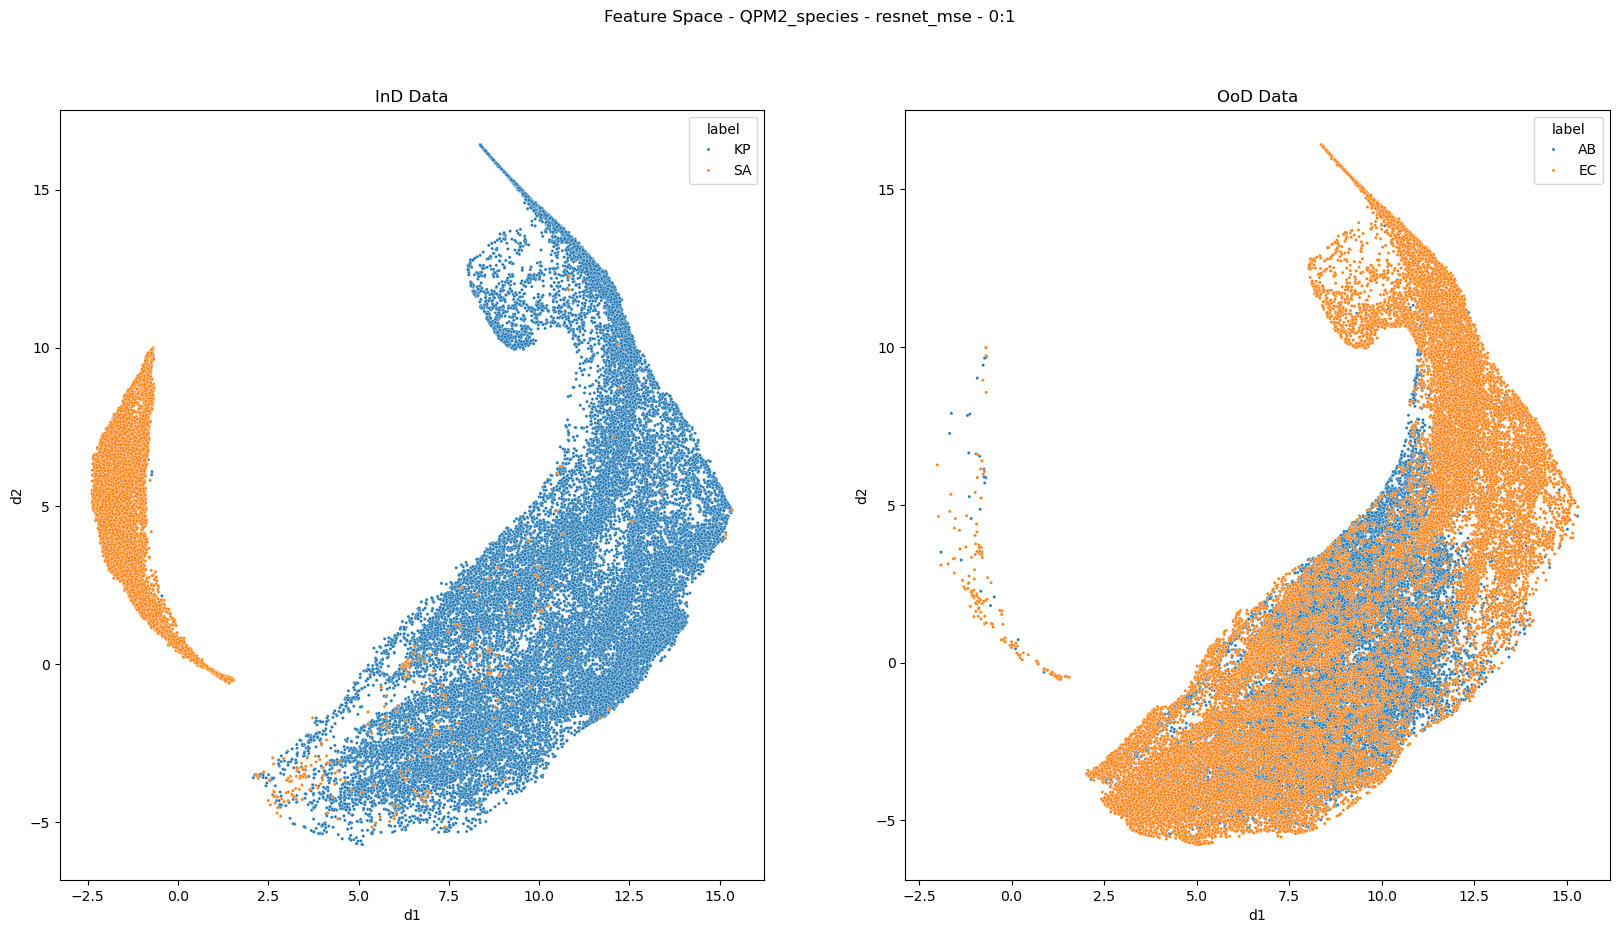

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

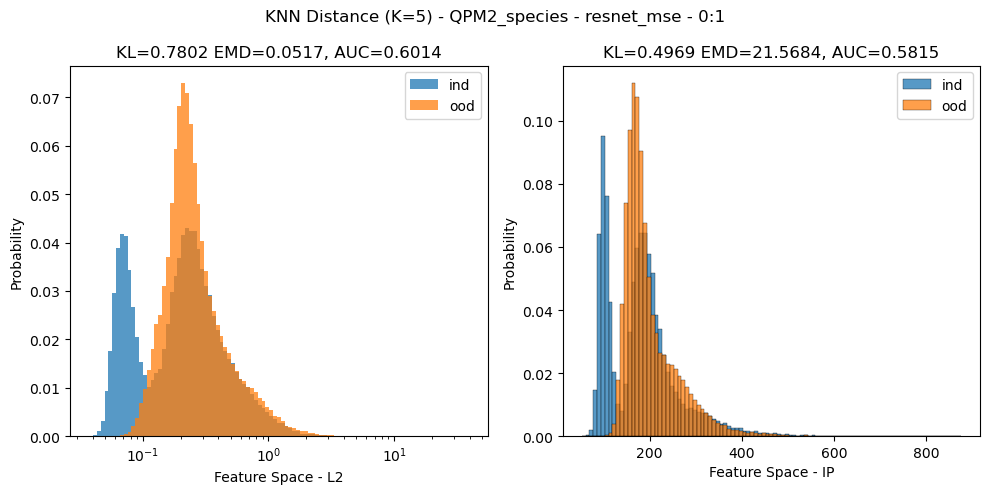

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

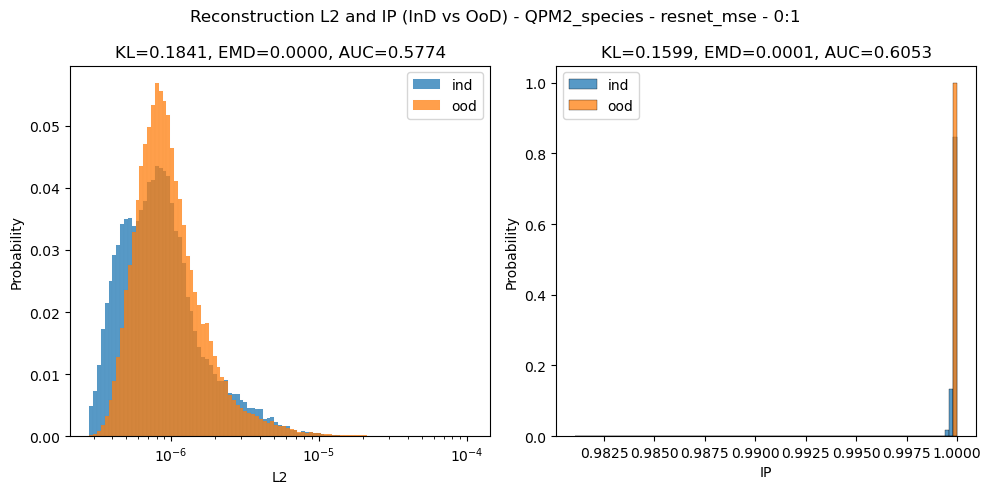

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)